In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm import tqdm
import pickle
from copy import deepcopy
from scipy.ndimage import gaussian_filter1d

In [3]:
NOTEBOOK_DIR = os.getcwd()
MODULE_DIR, _ = os.path.split(NOTEBOOK_DIR)
OUT_DIR = os.path.join(MODULE_DIR, "outputs")
sys.path.append(MODULE_DIR)

In [4]:
from longterm import load, utils
from longterm.utils import list_attr, list_fn, list_mthd, list_join
from longterm import plot as myplt

In [12]:
i_date = 826

if i_date == 20:
    exp_base_dir = os.path.join(load.NAS2_DIR_JB, "210720_olfac_pid")
elif i_date == 21:
    exp_base_dir = os.path.join(load.NAS2_DIR_JB, "210721_olfac_pid")
elif i_date == 22:
    exp_base_dir = os.path.join(load.NAS2_DIR_JB, "210722_olfac_pid")
elif i_date == 26:
    exp_base_dir = os.path.join(load.NAS2_DIR_JB, "210726_olfac_pid")
elif i_date == 826:
    exp_base_dir = os.path.join(load.NAS2_DIR_JB, "210826_olfac_pid")
sync_names = ["sync001", "sync002", "sync003", "sync004", "sync005", 
              "sync006", "sync007", "sync008", "sync009", "sync010",
              "sync011", "sync012", "sync013", "sync014"]
sync_out_files = [os.path.join(exp_base_dir, sync_name+".pkl") for sync_name in sync_names]

In [67]:
i_trial = 0
with open(sync_out_files[i_trial], "rb") as f:
    processed_lines = pickle.load(f)

In [68]:
processed_lines.keys()

dict_keys(['odor', 'pid', 'Times'])

In [69]:
t = processed_lines["Times"]
pid = gaussian_filter1d(processed_lines["pid"], sigma=100)
odor = gaussian_filter1d(processed_lines["odor"], sigma=100)

<IPython.core.display.Javascript object>


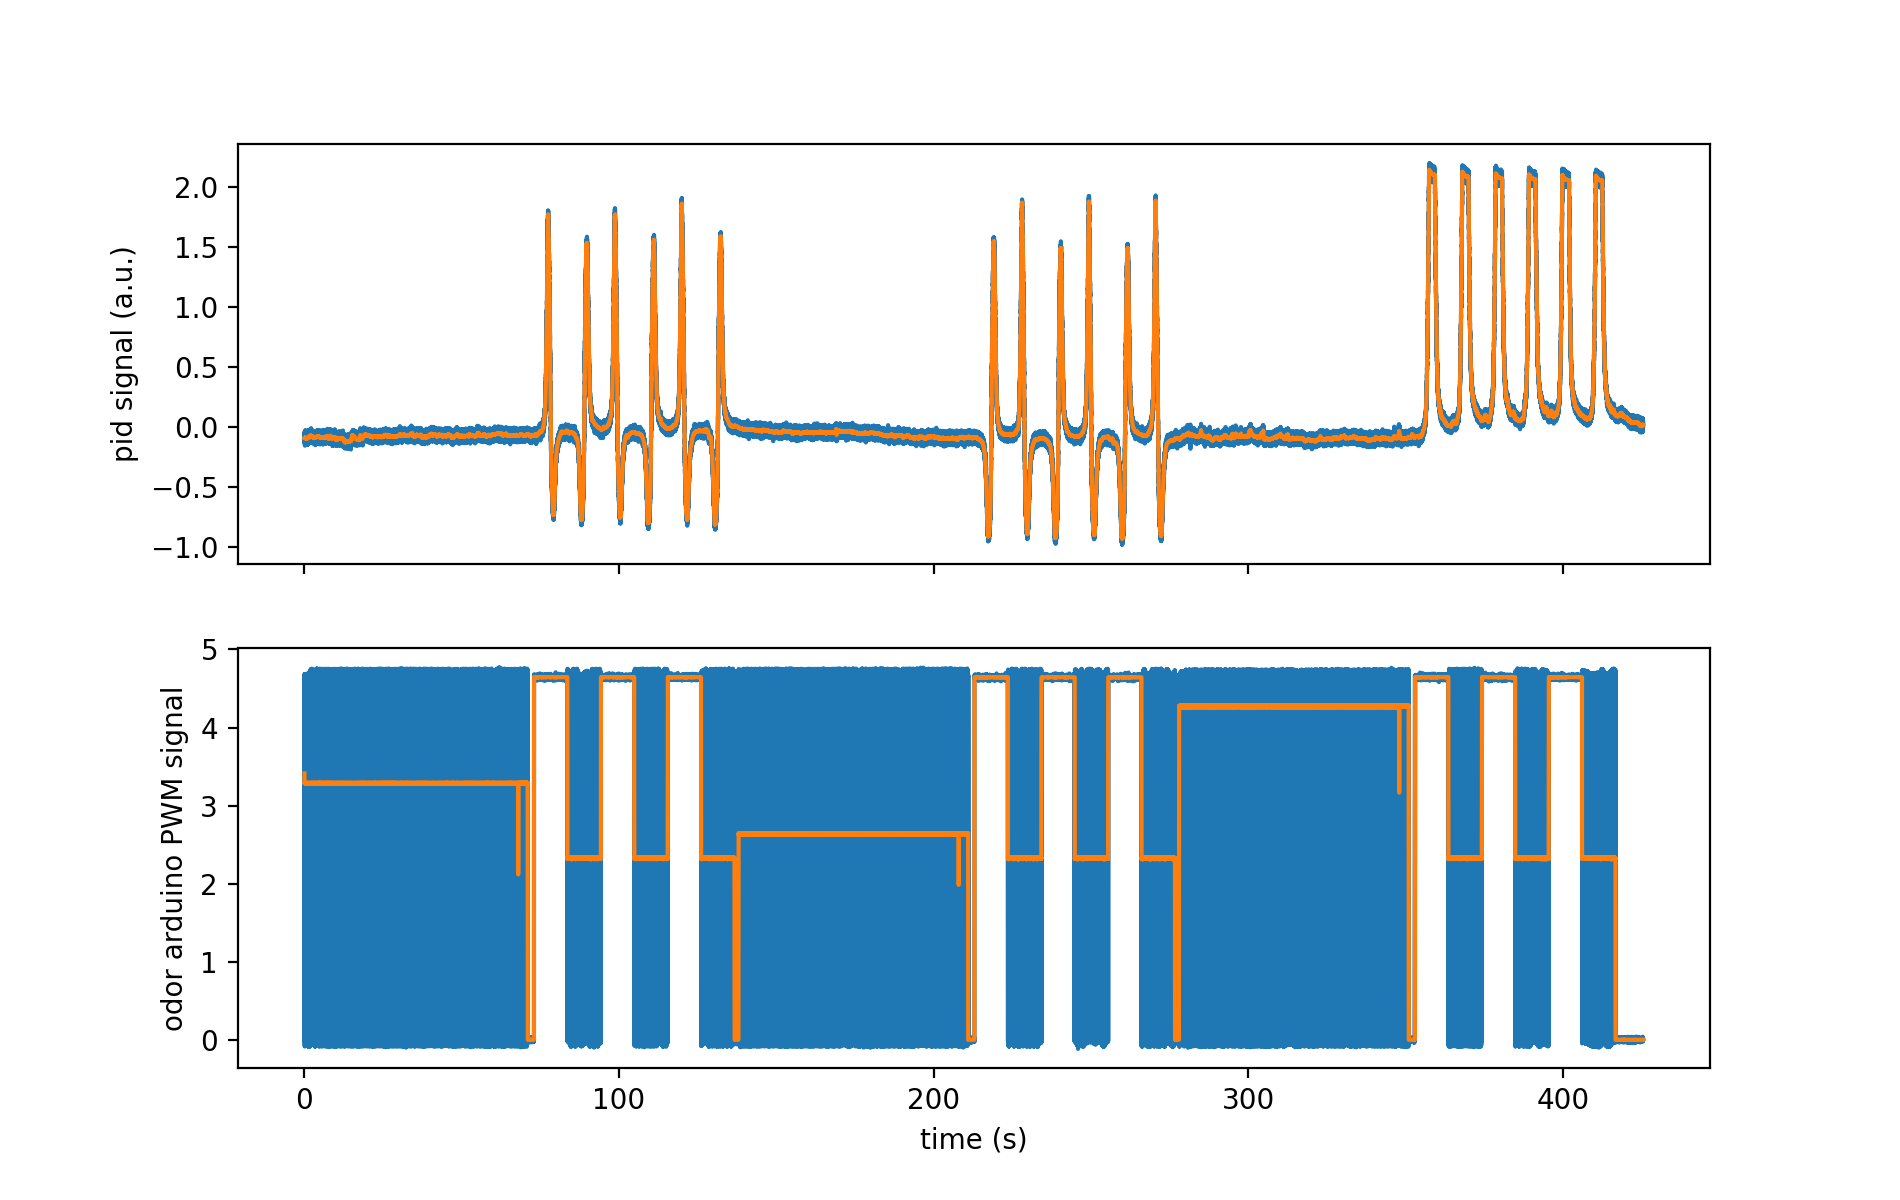

Text(0, 0.5, 'odor arduino PWM signal')

In [205]:
%matplotlib notebook
fig, axs = plt.subplots(2,1, figsize=(9.5, 6), sharex=True)  # , sharey=True)

axs[0].plot(t, processed_lines["pid"])
axs[0].plot(t, pid)
axs[0].set_ylabel("pid signal (a.u.)")

axs[1].plot(t, processed_lines["odor"])
axs[1].plot(t, odor)
# axs[1].plot(t, switch)
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("odor arduino PWM signal")

In [152]:
if i_date == 20 and i_trial == 0:
    offset = 62
    offset0 = 105
elif i_date == 20 and i_trial == 1:
    offset = 64
    offset0 = 107
elif i_date == 20 and i_trial == 2:
    offset = 63
    offset0 = 106
elif i_date == 21 and i_trial == 0:
    offset = 73
    offset0 = 417
elif i_date == 21 and i_trial == 1:
    offset = 74
    offset0 = 420 
elif i_date == 21 and i_trial == 2:
    offset = 74
    offset0 = 417     
elif i_date == 21 and i_trial == 8:
    offset = 74
    offset0 = 417     
    
odor_states = {"left": np.mean(odor[np.logical_and(t > offset,t < offset+9)]),
               "right": np.mean(odor[np.logical_and(t > offset+11,t < offset+20)]),
               "zero": np.mean(odor[np.logical_and(t > offset0,t < offset0+3)])}

In [167]:
odor_states

{'left': 4.644919089290644,
 'right': 2.3256935769561693,
 'zero': 0.0012208960009593979}

In [206]:
v_switch = np.mean([odor_states["left"], odor_states["right"]])
switch_right_0 = np.logical_and.reduce((odor >= v_switch, np.roll(odor, shift=1) < v_switch, 
                                     np.isclose(np.roll(odor, shift=100000), odor_states["right"], rtol=0.05),
                                     np.isclose(np.roll(odor, shift=-100000), odor_states["left"], rtol=0.05)))
v_switch_from0 = np.mean([odor_states["left"], odor_states["zero"]])
switch_right = np.logical_or(switch_right_0,
              np.logical_and.reduce((odor >= v_switch_from0, np.roll(odor, shift=1) < v_switch_from0, 
                                     np.isclose(np.roll(odor, shift=-100000), odor_states["left"], rtol=0.05),
                                     np.isclose(np.roll(odor, shift=50000), odor_states["zero"], atol=0.5)))
                           )

switch_left = np.logical_and.reduce((odor <= v_switch, np.roll(odor, shift=1) > v_switch, 
                                     np.isclose(np.roll(odor, shift=100000), odor_states["left"], rtol=0.1),
                                     np.isclose(np.roll(odor, shift=-100000), odor_states["right"], rtol=0.1)))

v_switch_to0 = np.mean([odor_states["right"], odor_states["zero"]])
switch_end = np.logical_or(switch_right_0,
              np.logical_and.reduce((odor <= v_switch_to0, np.roll(odor, shift=1) > v_switch_to0, 
                                     np.isclose(np.roll(odor, shift=100000), odor_states["right"], rtol=0.1)))
                           )

<IPython.core.display.Javascript object>


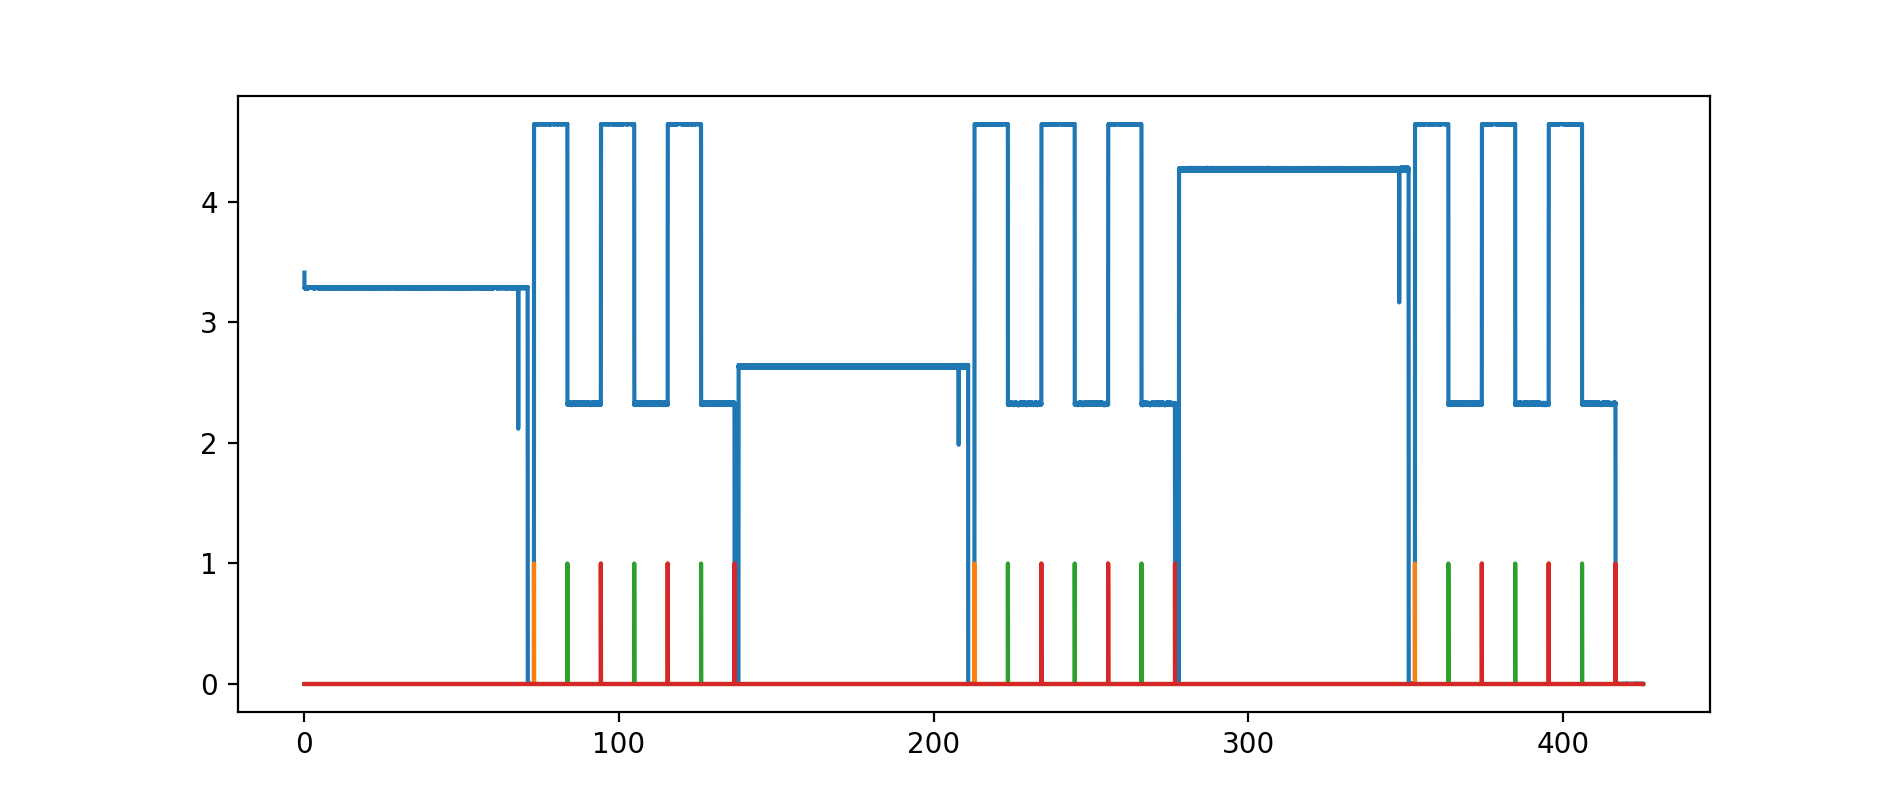

In [207]:
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(9.5, 4), sharex=True)  # , sharey=True)
ax.plot(t, odor)
# ax.plot(t, np.roll(odor, shift=100000))
ax.plot(t, switch_right)
ax.plot(t, switch_left)
ax.plot(t, switch_end)
# ax.plot(t, np.isclose(np.roll(odor, shift=-100000), odor_states["zero"], atol=0.5))
# ax.plot(t, np.logical_and.reduce((odor >= v_switch_from0, np.roll(odor, shift=1) < v_switch_from0)))




In [208]:
np.argwhere(switch_left) - np.argwhere(switch_right)

array([[318895],
       [318167],
       [318103],
       [318855],
       [318151],
       [318371],
       [318832],
       [318281],
       [318151]])

In [209]:
inds = [[0,1,2],[3,4,5],[6,7,8]]  # [[1],[3],[5]] # 

traces = []
all_traces = []
for ind in inds:
    tmp = []
    for i, start in enumerate(np.argwhere(switch_right).flatten()):
        if i in ind:
            tmp.append(pid[start:start+318000])
    for i, end in enumerate(np.argwhere(switch_end).flatten()):
        if i in ind:
            tmp.append(pid[end:end-318000:-1])
    traces.append(np.mean(tmp, axis=0))
    all_traces.append(tmp)
        

<IPython.core.display.Javascript object>


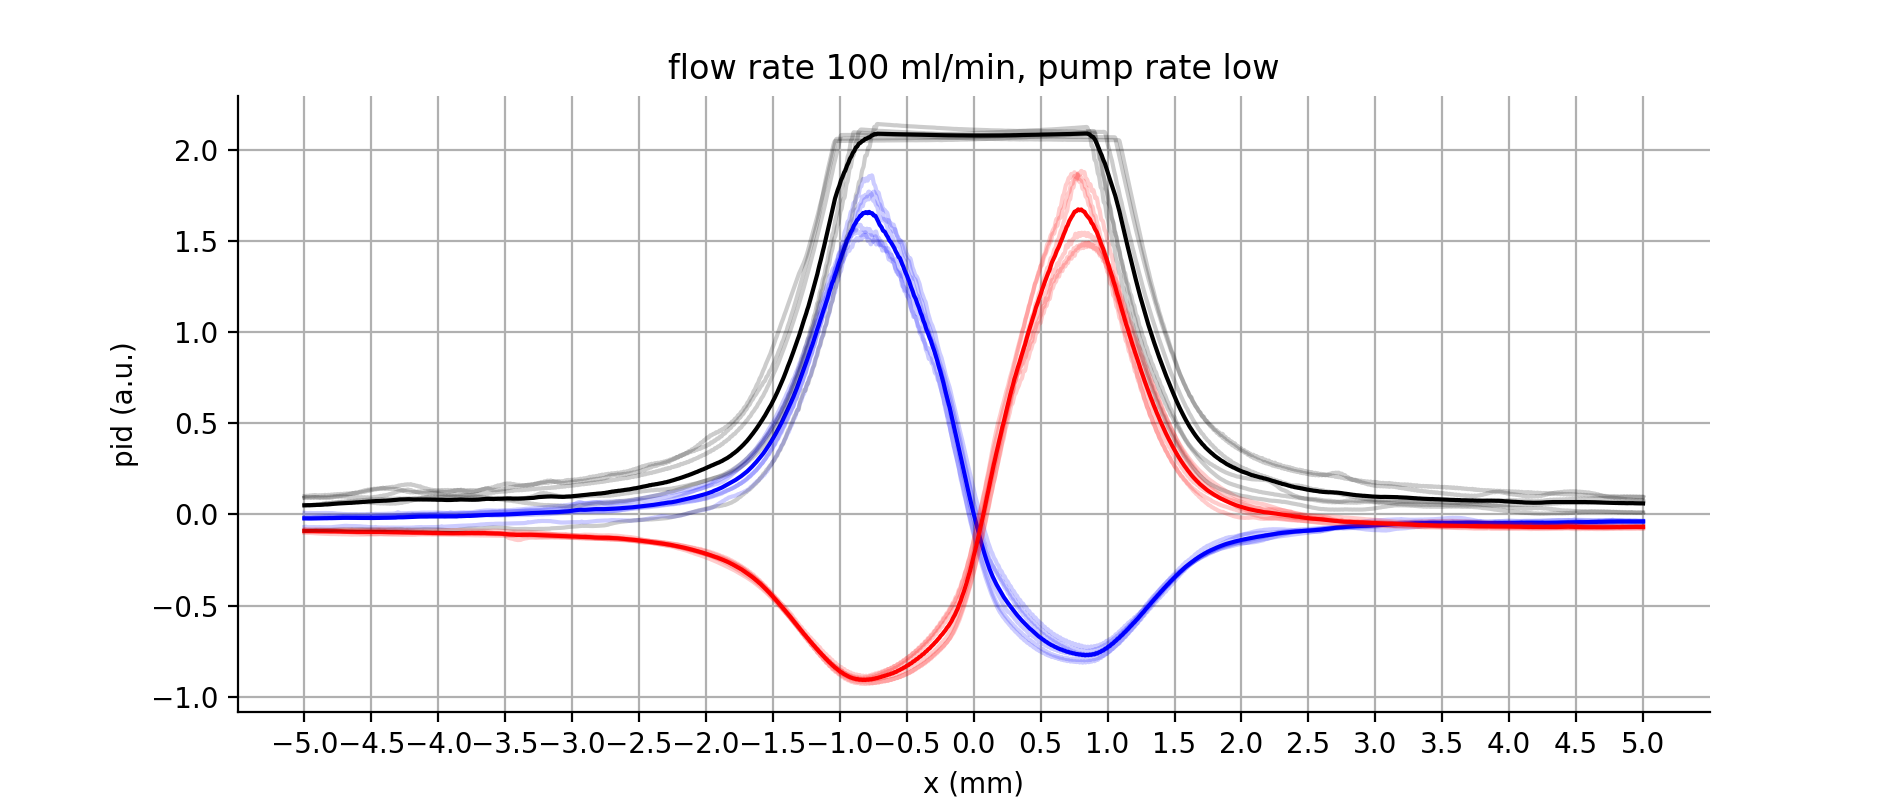

In [211]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(9.5,4))
v = 300000/318000  # mm/s 1000 # µm/s
t = np.arange(318000) / 30000
x = t * v - 5
colors = ["b", "r", "k"]
for all_tr, tr,c in zip(all_traces, traces, colors):
    ax.plot(x, np.array(all_tr).T, c, alpha=0.2)
    ax.plot(x, tr, c)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("x (mm)")
ax.set_ylabel("pid (a.u.)")
ax.set_title("flow rate 100 ml/min, pump rate low")
ax.grid()
ax.set_xticks(np.arange(-5,5.01, 0.5))

<IPython.core.display.Javascript object>


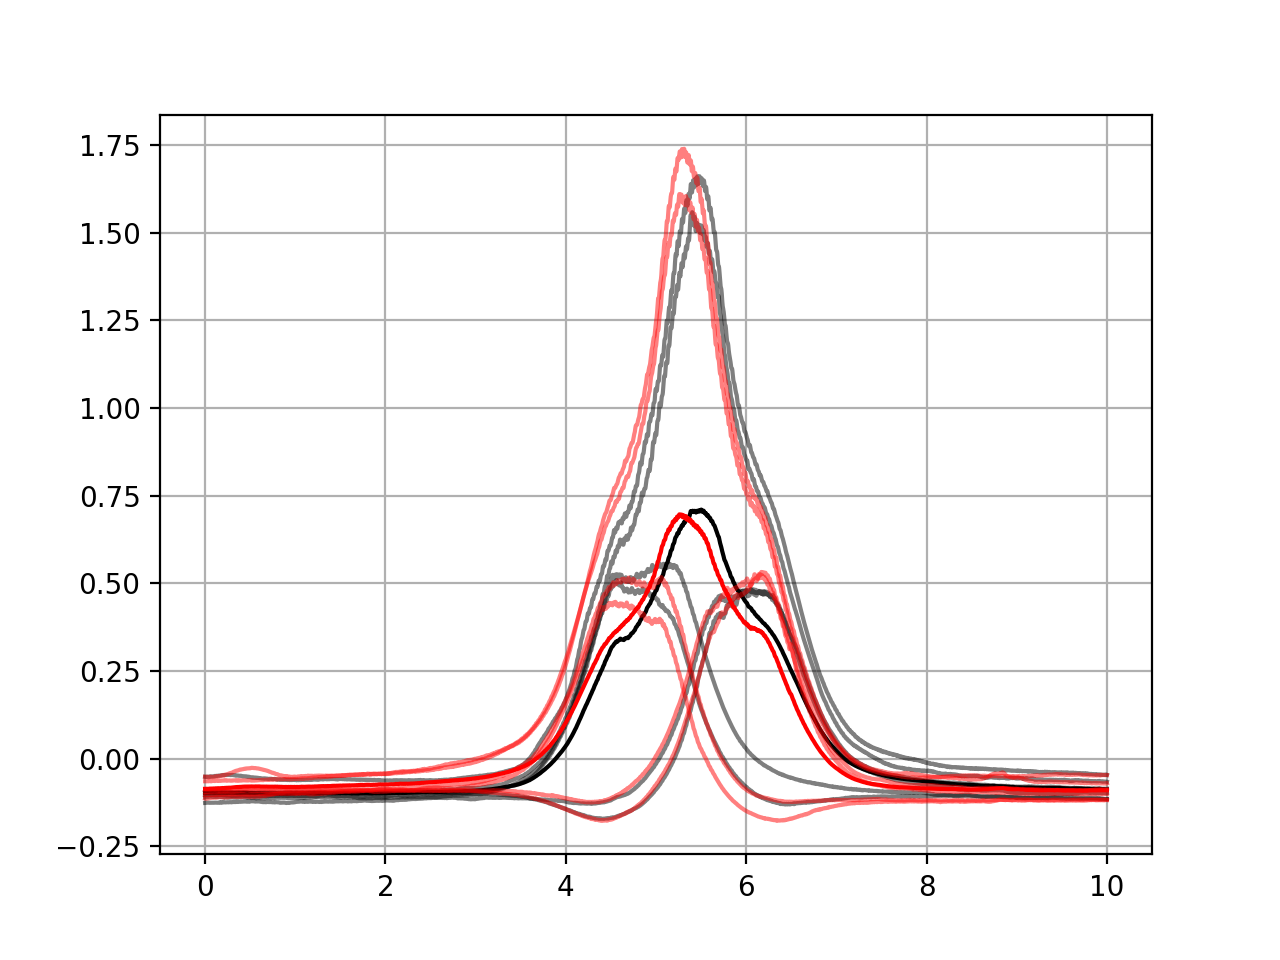

In [24]:
%matplotlib notebook

v = 1  # mm/s 1000 # µm/s
t = np.arange(300000) / 30000
x = t * v

i_list = [0,1,2,3,4,5]
tmp = []
for i, (start, end) in enumerate(zip(np.argwhere(switch_right).flatten(), np.argwhere(switch_left).flatten())):
    if i in i_list:
        signal = pid[start:start+300000]
        plt.plot(x, signal, "k", alpha=0.5)
        tmp.append(signal)
plt.plot(x, np.mean(tmp, axis=0), "k")
tmp = []
for i, (start, end) in enumerate(zip(np.argwhere(switch_left).flatten(), np.argwhere(switch_end).flatten())):
    if i in i_list:
        signal = np.flip(pid[start:end])[:300000]
        plt.plot(x, signal, "r", alpha=0.5)  
        tmp.append(signal)
plt.plot(x, np.mean(tmp, axis=0), "r")
plt.grid()

In [64]:
D = 1e-3          # m
r = D/2           # m  
A = r**2 * np.pi  # m^2
mfr = 100/1e6/60  # m^3/s
v_air = mfr / A   # m/s
v_air_kmh = v_air * 3.6
v_air_kmh

7.639437268410978

In [60]:
1e-3

0.001

# load switching on test

In [13]:
sync_out_files

['/mnt/NAS2/JB/210826_olfac_pid/sync001.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync002.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync003.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync004.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync005.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync006.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync007.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync008.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync009.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync010.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync011.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync012.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync013.pkl',
 '/mnt/NAS2/JB/210826_olfac_pid/sync014.pkl']

In [62]:
i_trial = 0
with open(sync_out_files[i_trial], "rb") as f:
    processed_lines = pickle.load(f)

In [63]:
t2 = processed_lines["Times"]
t2 = t2[t2<7300]

In [64]:
pid2 = processed_lines["pid"][:len(t2)]  # gaussian_filter1d(processed_lines["pid"][:len(t2)], sigma=100)
odor2 = gaussian_filter1d(processed_lines["odor"][:len(t2)], sigma=100)

In [65]:
del processed_lines

<IPython.core.display.Javascript object>


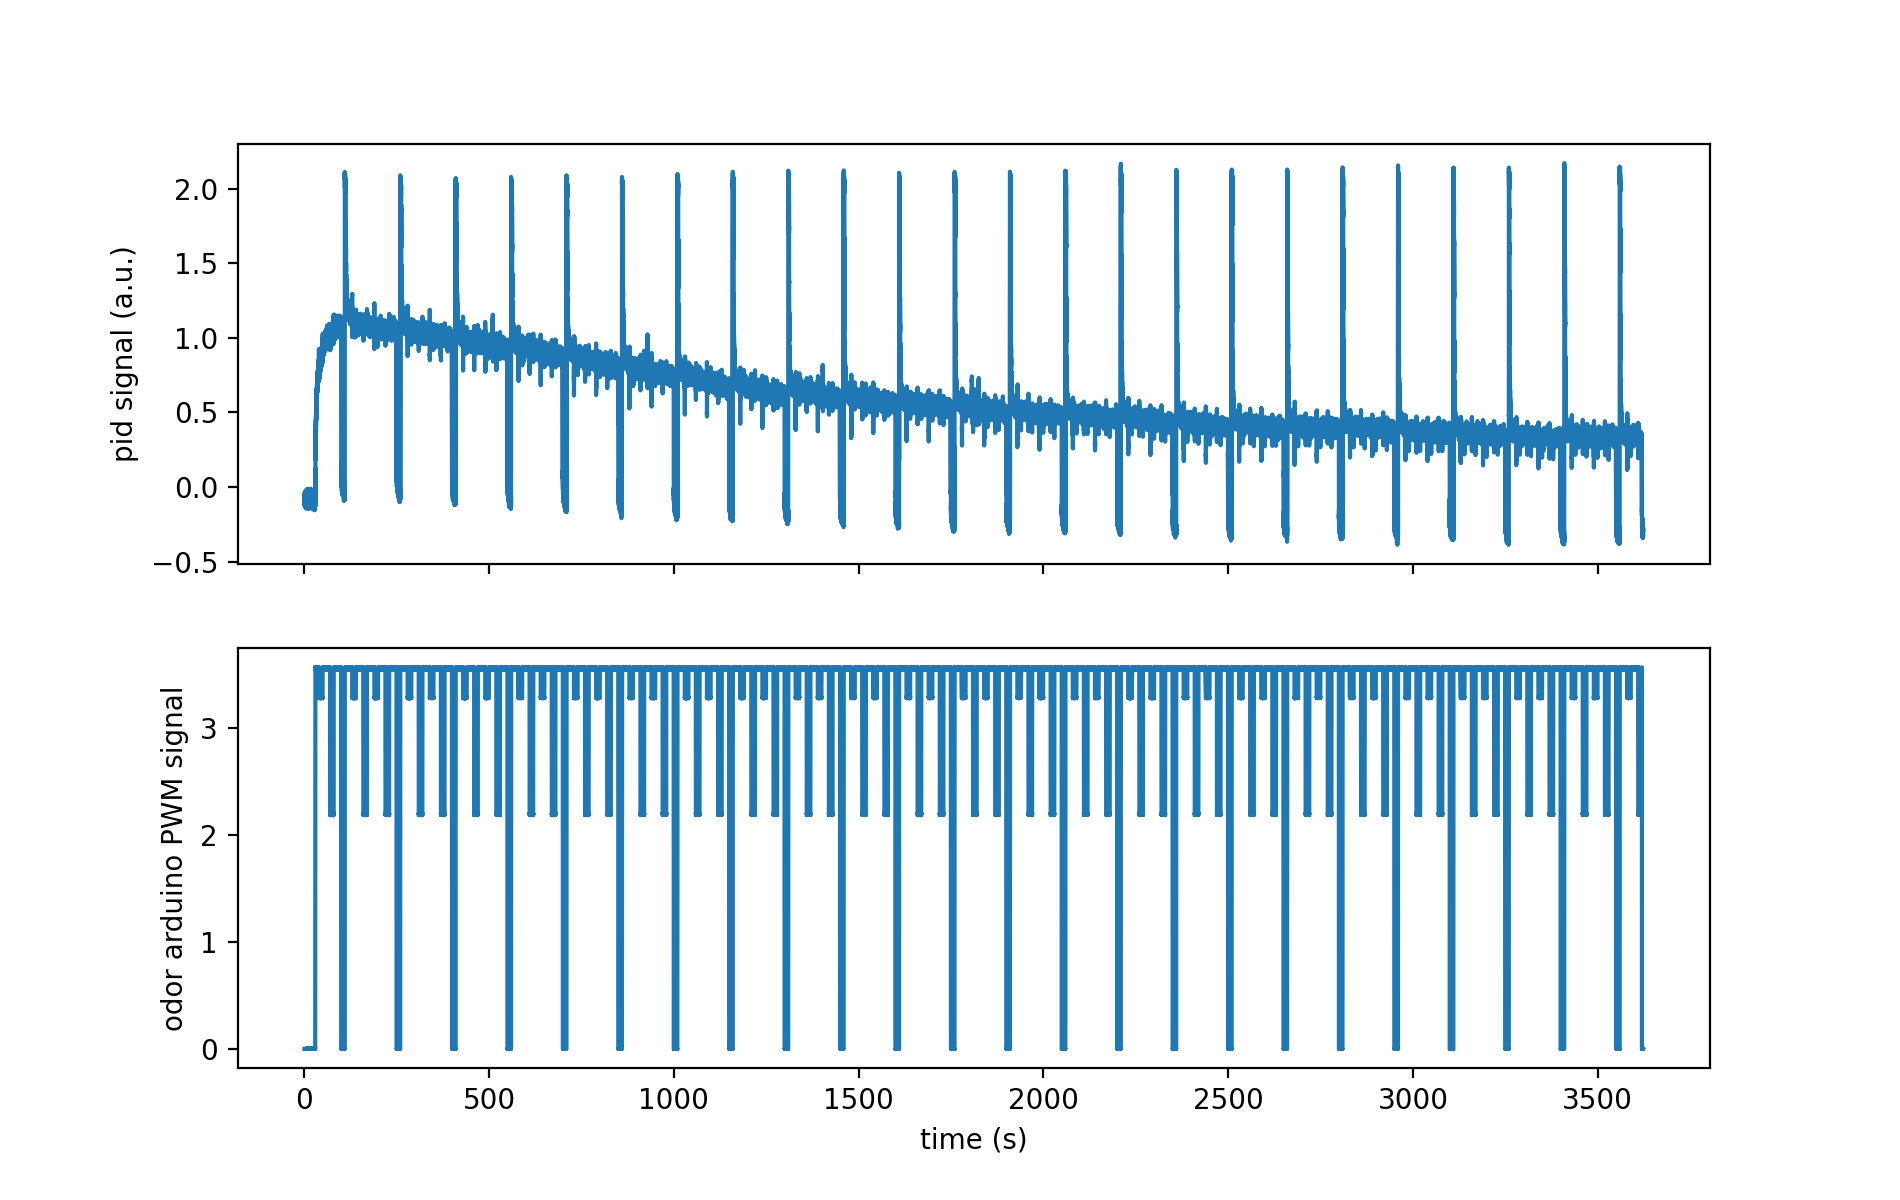

Text(0, 0.5, 'odor arduino PWM signal')

In [66]:
%matplotlib notebook
fig, axs = plt.subplots(2,1, figsize=(9.5, 6), sharex=True)  # , sharey=True)

# axs[0].plot(processed_lines["Times"], processed_lines["pid"])
axs[0].plot(t2, pid2)
axs[0].set_ylabel("pid signal (a.u.)")

# axs[1].plot(processed_lines["Times"], processed_lines["odor"])
axs[1].plot(t2, odor2)
# axs[1].plot(t, switch)
axs[1].set_xlabel("time (s)")
axs[1].set_ylabel("odor arduino PWM signal")

In [19]:
v_t = 3.4  # 2.2  # V

In [28]:
switch2 = np.logical_and(odor2 <= v_t, np.roll(odor2, shift=1) > v_t)
# switch2 = np.logical_and(odor2 >= v_t, np.roll(odor2, shift=1) < v_t)

<IPython.core.display.Javascript object>


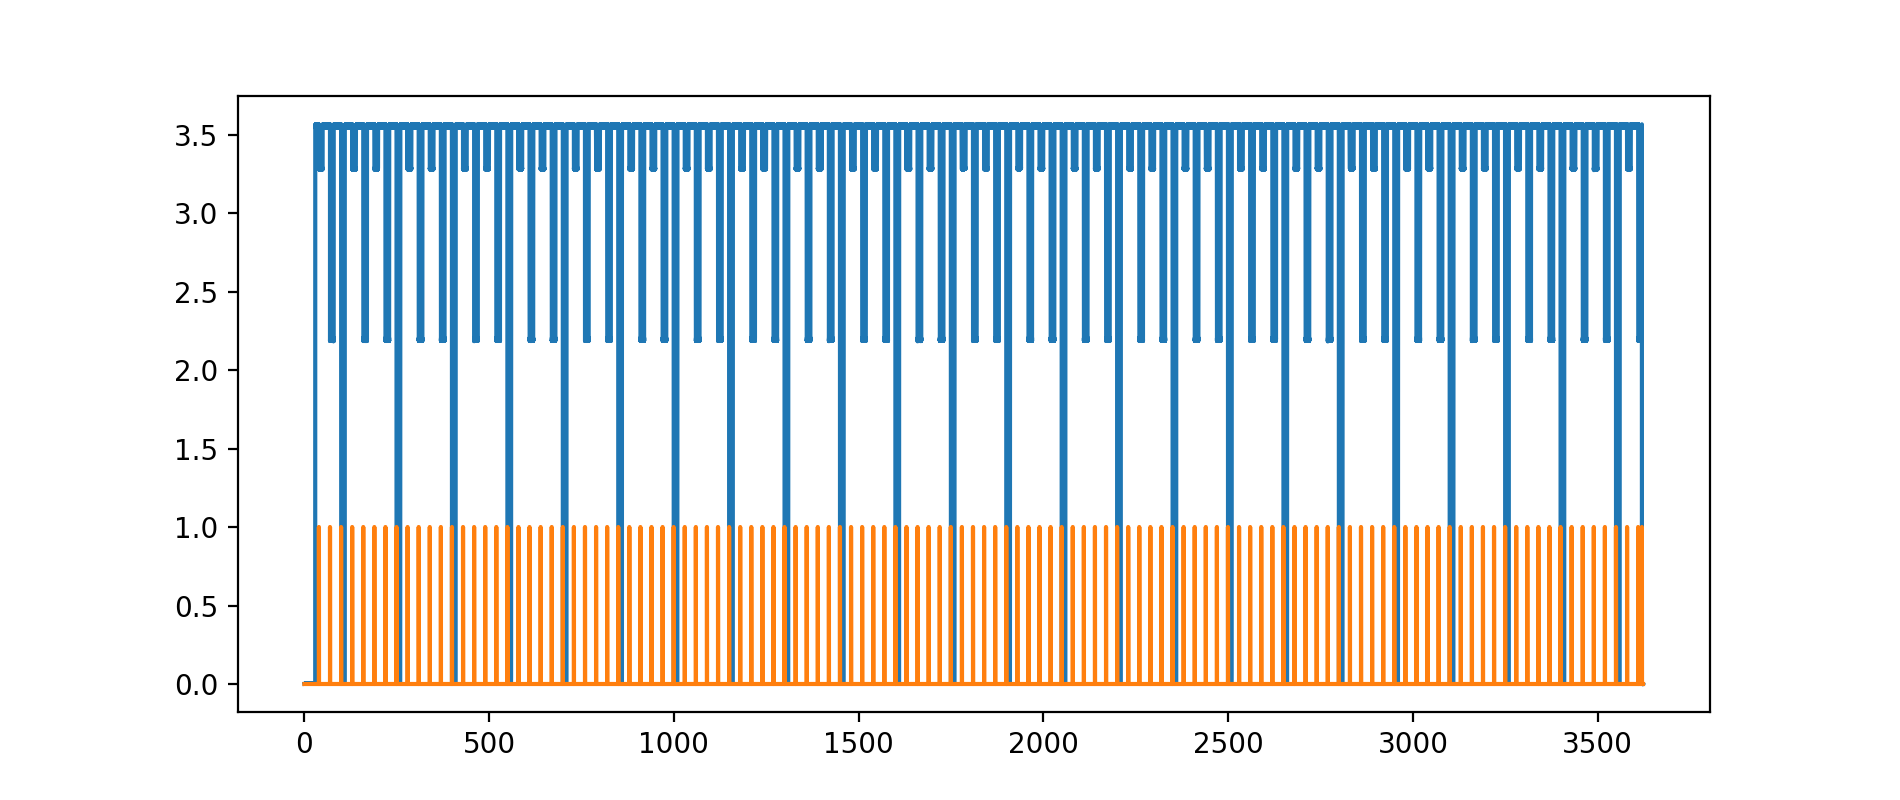

In [29]:
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(9.5, 4), sharex=True)  # , sharey=True)
ax.plot(t2, odor2)
ax.plot(t2, switch2)


In [70]:
np.sum(switch2==1)

121

In [71]:
traces2 = []
traces_cond1 = []
traces_cond2 = []
traces_cond3 = []
for start in tqdm(np.argwhere(switch2==1).flatten()[:-2]):  #TODO: remove the [:-1] at some point
    # signal = pid2[start-60000:start+450000:30]  # gaussian_filter1d(, sigma=1)  # 60000, 450000, 3000 without subsampling
    signal = pid2[start-60000:start+450000]
    # traces2.append(signal - np.mean(signal[:60000//30]))
    traces2.append(signal - np.mean(signal[:60000]))
    if odor2[start+6000] > 3:
        traces_cond1.append(signal - np.mean(signal[:60000]))  # //30
    elif odor2[start+6000] > 2:
        traces_cond2.append(signal - np.mean(signal[:60000]))  # //30
    else:
        traces_cond3.append(signal - np.mean(signal[:60000]))  # //30

100%|██████████| 119/119 [00:00<00:00, 443.06it/s]


In [31]:
len(traces2)

120

<IPython.core.display.Javascript object>


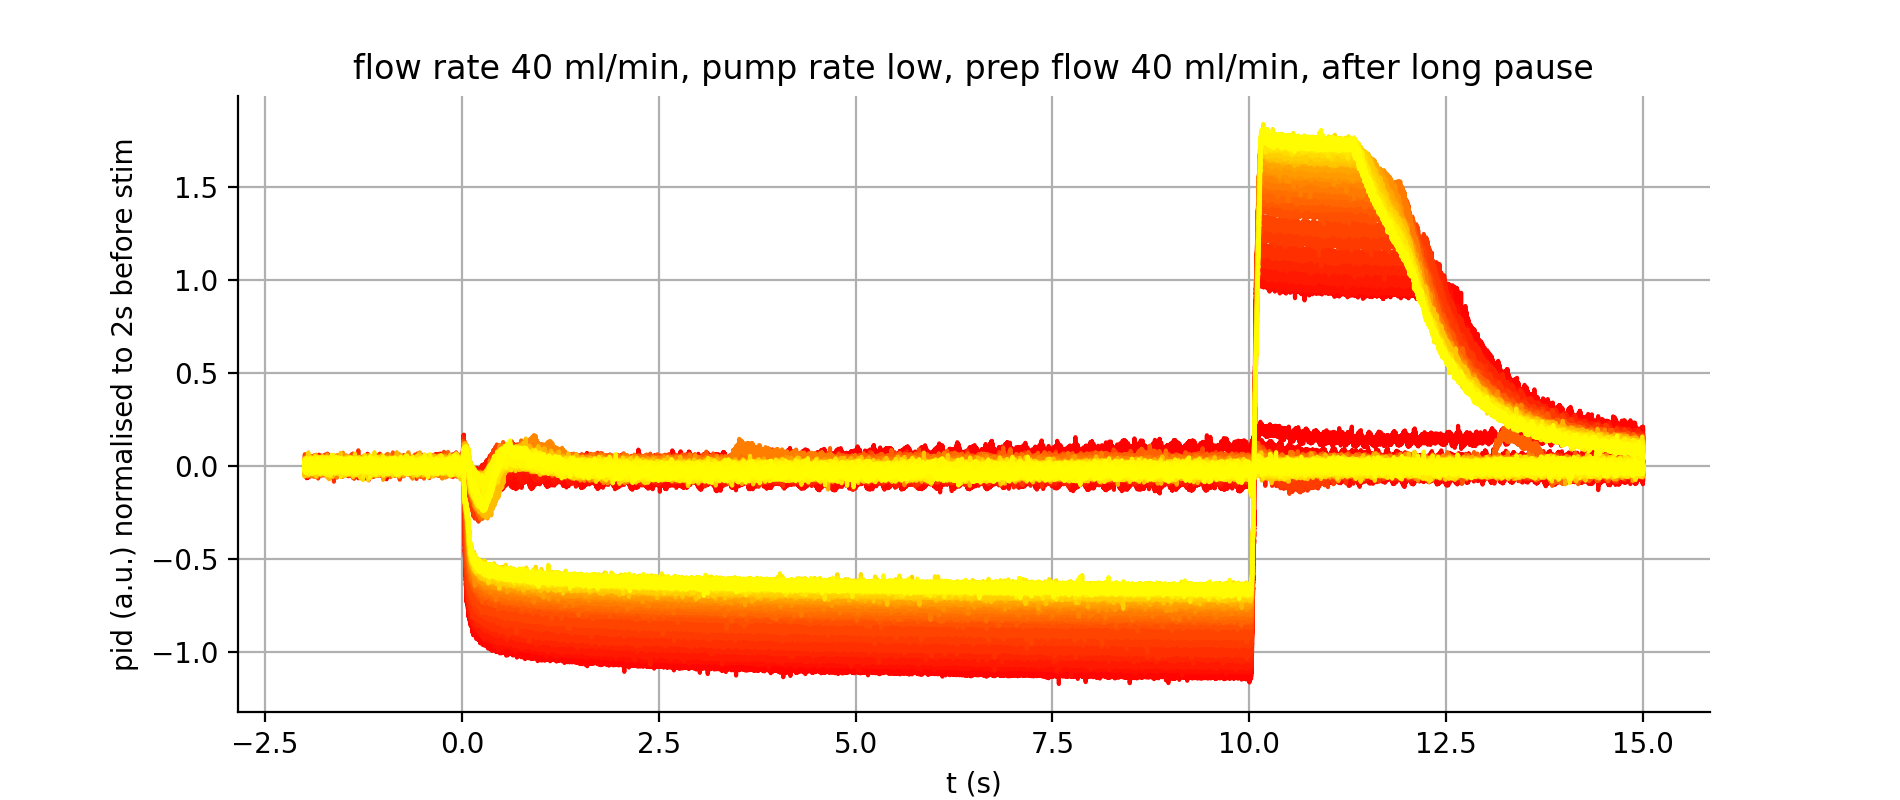

In [73]:
%matplotlib notebook
N_traces = len(traces2)
fig, ax = plt.subplots(figsize=(9.5,4))
# t2 = np.arange(15000+2000) / 1000 - 2  
t2 = np.arange(450000+60000) / 30000 - 2
for i, tr in enumerate(traces2[:N_traces]):
    ax.plot(t2, tr, color=plt.cm.get_cmap("autumn")(i/N_traces))  
    # np.mean(tr[300000:330000])  # /np.mean(tr[10000:11000])
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t (s)")
ax.set_ylabel("pid (a.u.) normalised to 2s before stim")  #  and 8-9s of stim")
ax.set_title("flow rate 40 ml/min, pump rate low, prep flow 40 ml/min, after long pause")
ax.grid()
# ax.set_xticks(np.arange(-2, 15.01, 1))

<IPython.core.display.Javascript object>


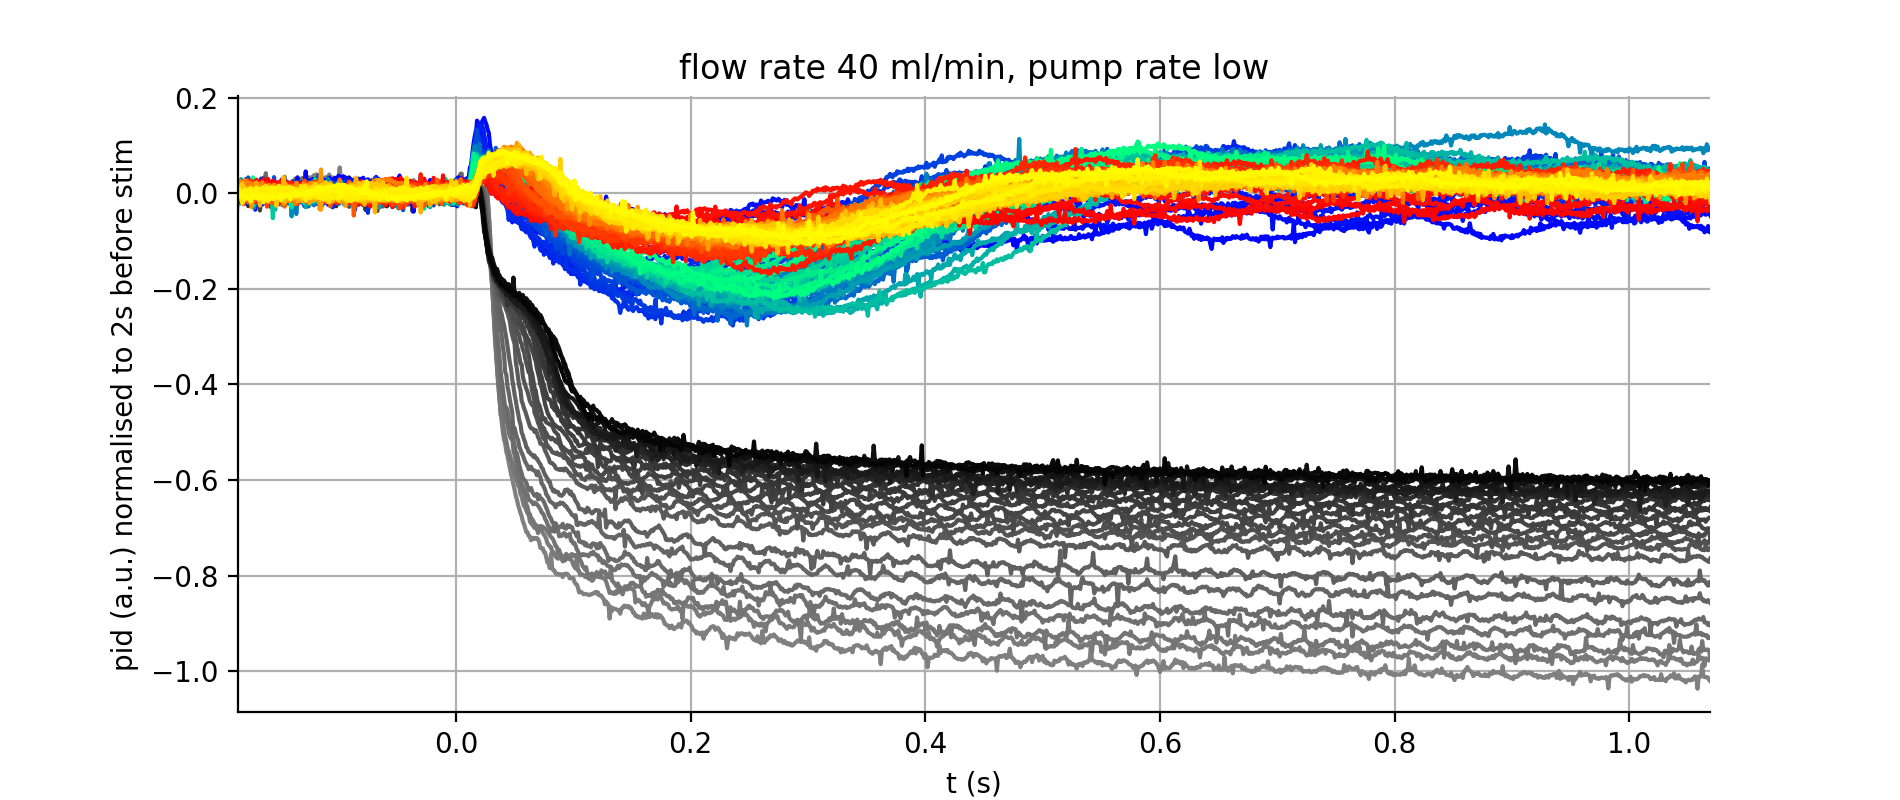

In [69]:
%matplotlib notebook
N_traces = len(traces2)
fig, ax = plt.subplots(figsize=(9.5,4))
t2 = np.arange(15000+2000) / 1000 - 2  # np.arange(450000+60000) / 30000 - 2
for i, tr in enumerate(traces_cond3):
    ax.plot(t2, tr, color=plt.cm.get_cmap("gray")(0.5-0.5*i/len(traces_cond3)))  

for i, tr in enumerate(traces_cond1):
    ax.plot(t2, tr, color=plt.cm.get_cmap("winter")(i/len(traces_cond2))) 

for i, tr in enumerate(traces_cond2):
    ax.plot(t2, tr, color=plt.cm.get_cmap("autumn")(i/len(traces_cond2)))  
    # np.mean(tr[300000:330000])  # /np.mean(tr[10000:11000])
    


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t (s)")
ax.set_ylabel("pid (a.u.) normalised to 2s before stim")  #  and 8-9s of stim")
ax.set_title("flow rate 40 ml/min, pump rate low")  # , prep flow 40 ml/min, after long pause")
ax.grid()
# ax.set_xticks(np.arange(-2, 15.01, 1))